Travail réalisé par Aginth Muthulingam 

## Chargement des modules

In [93]:
import pandas as pd
import numpy as np
import random
import re
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from function import *


from sklearn.impute import KNNImputer 
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV , cross_validate
from sklearn.compose import make_column_selector, make_column_transformer , ColumnTransformer 
from category_encoders import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn import linear_model , metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score

## Chargement base de données

In [94]:
df_clean = pd.read_csv('dataset_cleane.csv')
df_clean = df_clean.drop(['TotalGHGEmissions_log'],axis=1)

## Skewness

Nous avons une skewness relativement élévé pour plusieurs variable , il serait donc judicieux de les passer au log les variable ayant une skewness > 2 afin de voir si cela peut améliorer la performance de nos modèles 

In [95]:
df_clean_log = log_transform (df_clean)
#df_clean_log.skew(axis = 0, skipna = True).sort_values(ascending=False)

## Modélisation 

les 2 variables qu'on souhaite prédire sont :
- SiteEnergyUseWN(kBtu)_log

### Mise en place des modèles 

In [96]:
# Features : all columns, except targets
X = df_clean.copy().drop(columns=[ 'SiteEnergyUseWN(kBtu)_log','ENERGYSTARScore'])
X_log = df_clean_log.copy().drop(columns=[ 'SiteEnergyUseWN(kBtu)_log','ENERGYSTARScore']) 

cible1 = 'SiteEnergyUseWN(kBtu)_log'

y = df_clean.copy()[cible1]
y_log = df_clean_log.copy()[cible1]

In [192]:
numerical_feature = make_column_selector(dtype_include=np.number)
categorical_feature = make_column_selector(dtype_exclude=np.number)

In [193]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [194]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_feature),
                                               ('cat', categorical_transformer, categorical_feature)])

In [195]:
#baseline 
dummy = Pipeline(steps=[('prepa',preprocessor),('dummy',DummyRegressor())])

# Modele à tester

linear = Pipeline(steps=[('prepa',preprocessor),('linear',linear_model.LinearRegression())])
KNN = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor())])
forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(random_state=0))])
ADA = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(random_state=0,))])
MLPr = Pipeline(steps=[('prepa',preprocessor),('MLPr',MLPRegressor(random_state=0, max_iter=10000))])

In [101]:
ls_model = [dummy,linear,KNN,forest,ADA,MLPr]
dico_model = {0: "dummy", 1: "lr",2:'KNN',3:'forest',4:'adaboost',5:"Multi Layer Perceptron"}

### Comparaison avec variables normal vs variables log

In [102]:
analyse_un = analyse_modele (X,y,ls_model,dico_model)
analyse_un_log = analyse_modele (X_log,y_log,ls_model,dico_model)

In [103]:
analyse_un

,RMSE,MAE,R2
dummy,1.600831,1.111330,-0.314504
lr,62.172721,37.187326,-3157.384857
KNN,1.438461,0.816927,-0.006201
forest,1.157049,0.517862,0.402816
adaboost,1.410031,0.799241,0.035640
Multi Layer Perceptron,2.254506,1.570182,-1.770680


In [104]:
analyse_un_log

,RMSE,MAE,R2
dummy,1.600831,1.111330,-0.314504
lr,8.928355,5.439739,-56.256209
KNN,1.350427,0.736835,0.148611
forest,1.156751,0.517939,0.403341
adaboost,1.395702,0.784397,0.052405
Multi Layer Perceptron,2.034153,1.439052,-1.359702


lr semble trop incohérent

In [105]:
analyse_un.drop('lr',inplace=True)
analyse_un_log.drop('lr',inplace=True)

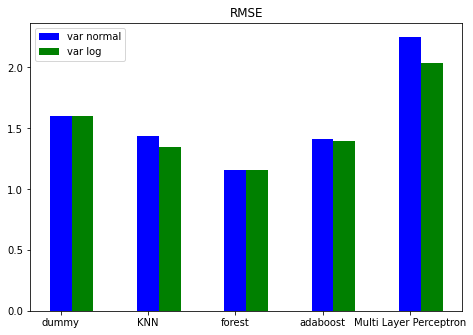

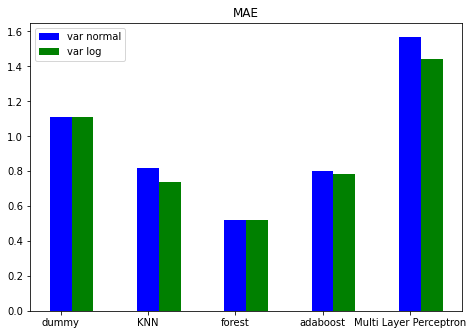

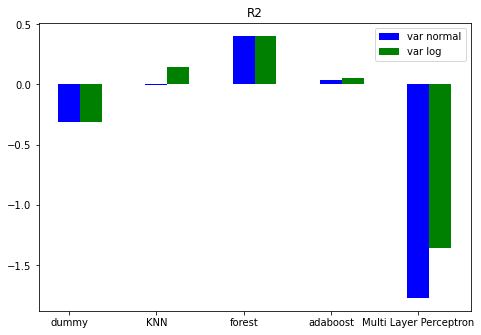

In [106]:
for i in analyse_un.columns : 
    plot_metrics1 (analyse_un,analyse_un_log,i)

### Recherche hyperparamètres modèles

In [70]:
# On splite les données 
X_train, X_test, y_train, y_test = train_test_split(X_log, y,test_size=0.2,random_state=0)

#### Random Forest

In [ ]:
params_forest = {"forest__n_estimators" : list(np.arange(110,140)),
                 'forest__min_samples_leaf': list(np.arange(1,10)),
                 'forest__max_depth' : list(np.arange(1,15))
}

forest_cv = GridSearchCV(forest,params_forest,cv=4)
forest_cv = forest_cv.fit (X_train, y_train)

print("Best Parameters: {}".format(forest_cv.best_params_))
print("Best score: {}".format(forest_cv.best_score_))

#Temps = 1h30 

In [109]:
forest_max = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=138, max_depth =14,
                                                                               min_samples_leaf=1
                                                                              ))])

score = cross_validate(forest_max,X_log,y,cv=4,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error','r2'))
rmse_forest = -score['test_neg_root_mean_squared_error'].mean()
r2_forest = score['test_r2'].mean()
msa_forest = -score['test_neg_mean_absolute_error'].mean()

result_forest = [rmse_forest,msa_forest,r2_forest]
result_forest

[1.1633644144863273, 0.5208646474292038, 0.3947687042505129]

#### KNN

In [ ]:
params_kNN = {"kNN__n_neighbors" : list(np.arange(3,20)),
              'kNN__leaf_size' : list(np.arange(1,40)),
              'kNN__p' : [1,2]
}

kNN_cv = GridSearchCV(KNN,params_kNN,cv=4)
kNN_cv = kNN_cv.fit (X_train, y_train)

print("Best Parameters: {}".format(kNN_cv.best_params_))
print("Best score: {}".format(kNN_cv.best_score_))

In [110]:
kNN_max = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor(n_neighbors=11, p =2,
                                                                            leaf_size=1
                                                                              ))])

score = cross_validate(kNN_max,X_log,y,cv=4,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error','r2'))
rmse_knn = -score['test_neg_root_mean_squared_error'].mean()
r2_knn = score['test_r2'].mean()
msa_knn = -score['test_neg_mean_absolute_error'].mean()

result_knn = [rmse_knn,msa_knn,r2_knn]
result_knn

[1.3236330622327128, 0.750960995999044, 0.18616429414122002]

#### Adaboost

In [ ]:
params_ADA={"ADA__n_estimators" : list(np.arange(1,80)),
            "ADA__loss" : ['linear', 'square', 'exponential']   
}

ADA_cv = GridSearchCV(ADA, params_ADA, cv =4)
ADA_cv = ADA_cv.fit (X_train, y_train)

print("Best Parameters: {}".format(ADA_cv.best_params_))
print("Best score: {}".format(ADA_cv.best_score_))

In [140]:
ADA_max = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(n_estimators = 1, loss = 'linear', 
                                                                          random_state=0,))])
score = cross_validate(ADA_max,X_log,y,cv=3,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error','r2'))
rmse_ada = -score['test_neg_root_mean_squared_error'].mean()
r2_ada = score['test_r2'].mean()
msa_ada = -score['test_neg_mean_absolute_error'].mean()

result_ada = [rmse_ada,msa_ada,r2_ada]
result_ada

[1.34512406776307, 0.6914262912948953, 0.20733681486744915]

#### Multi Layer Perceptron

In [138]:
params_MLPr={"MLPr__hidden_layer_sizes" : list(np.arange(90,110)),
            "MLPr__activation" : ['identity', 'logistic', 'tanh', 'relu']
}

MLPr_cv = GridSearchCV(MLPr, params_MLPr, cv =4)
MLPr_cv = MLPr_cv.fit (X_train, y_train)

print("Best Parameters: {}".format(MLPr_cv.best_params_))
print("Best score: {}".format(MLPr_cv.best_score_))

C:\Users\Agint\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Best Parameters: {'MLPr__activation': 'tanh', 'MLPr__hidden_layer_sizes': 95}
Best score: -0.3014110424093665


In [112]:
MLPr_max = Pipeline(steps=[('prepa',preprocessor),('MLPr',MLPRegressor(hidden_layer_sizes =95, activation = 'tanh', 
                                                                          random_state=0,max_iter = 10000 ))])
score = cross_validate(MLPr_max,X_log,y,cv=4,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error','r2'))
rmse_MLPr = -score['test_neg_root_mean_squared_error'].mean()
r2_MLPr = score['test_r2'].mean()
msa_MLPr = -score['test_neg_mean_absolute_error'].mean()

result_MLPr = [rmse_MLPr,msa_MLPr,r2_MLPr]
result_MLPr

[1.717468780968857, 1.295822063482101, -0.6667340416093507]

### Comparaison des modèles 

In [113]:
analyse_un_log2 = analyse_un_log.copy().drop('dummy')

In [114]:
analyse_opt = pd.DataFrame([result_knn, result_forest, result_ada,result_MLPr],columns = ['RMSE','MAE','R2'],
                           index = ['KNN','forest','adaboost','Multi Layer Perceptron'])

In [115]:
analyse_opt

,RMSE,MAE,R2
KNN,1.323633,0.750961,0.186164
forest,1.163364,0.520865,0.394769
adaboost,1.345124,0.691426,0.207337
Multi Layer Perceptron,1.717469,1.295822,-0.666734


In [116]:
analyse_un_log2

,RMSE,MAE,R2
KNN,1.350427,0.736835,0.148611
forest,1.156751,0.517939,0.403341
adaboost,1.395702,0.784397,0.052405
Multi Layer Perceptron,2.034153,1.439052,-1.359702


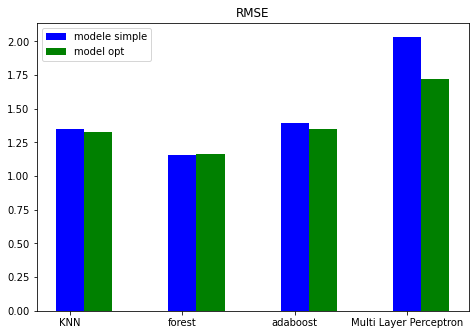

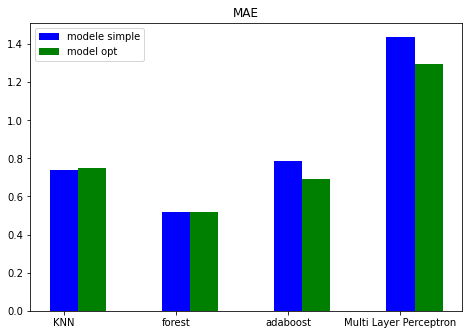

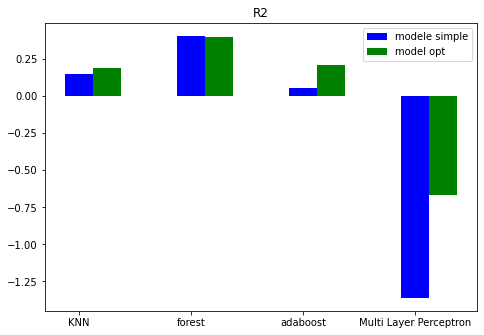

In [117]:
for i in analyse_un_log2.columns :
    plot_metrics2 (analyse_un_log2,analyse_opt,i)

## Modèle choisi : RandomForest

### Feature importance

#### Methode 1 : permutation importance

In [158]:
forest_max = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=138, max_depth =14,
                                                                               min_samples_leaf=1
                                                                              ))])
forest_max.fit(X_train,y_train)
perm_importance = permutation_importance(forest_max, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

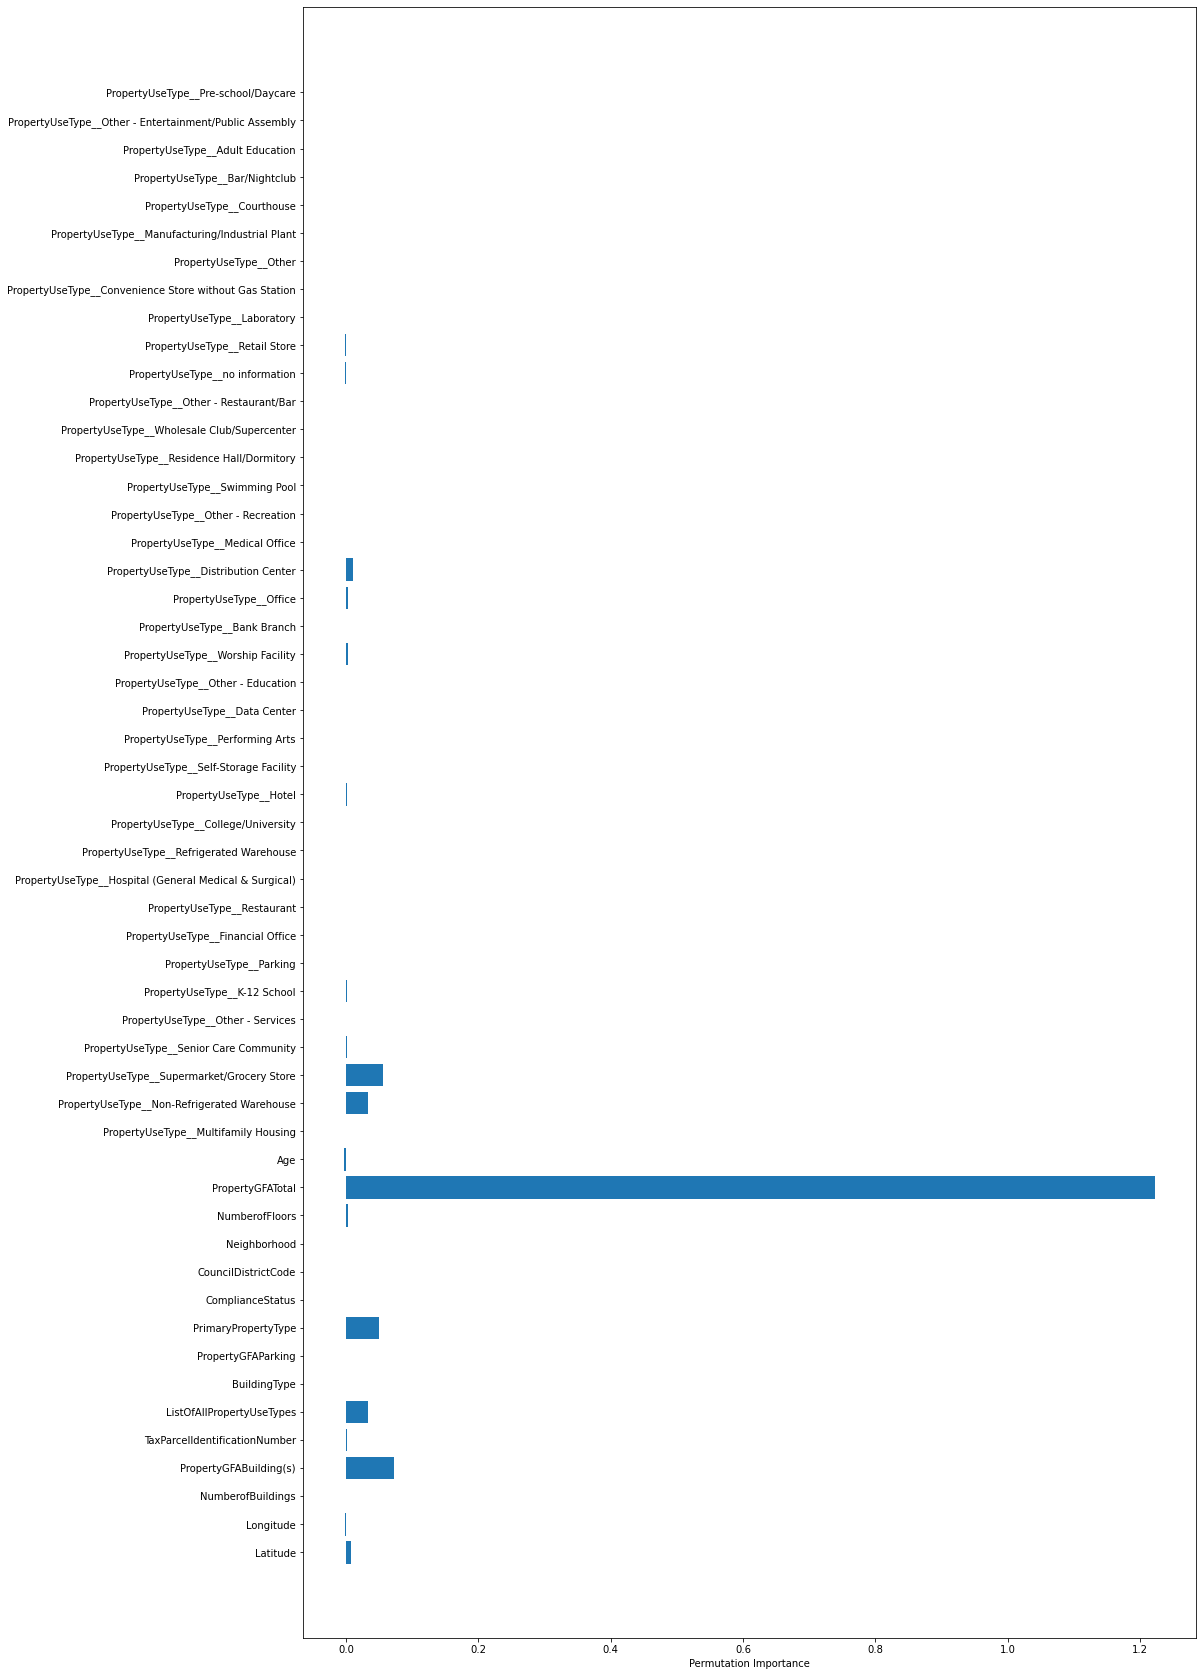

In [159]:
plt.figure(figsize=(16, 30))
plt.barh(X_train.columns, perm_importance.importances_mean)
plt.xlabel("Permutation Importance")

#### Methode 2 : shap

In [196]:
import shap
shap.initjs()

forest_max = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=138, max_depth =14,
                                                                               min_samples_leaf=1
                                                                              ))])

forest_max['forest'].fit(forest_max['prepa'].fit_transform(X_train),y_train)

shap_explainer = shap.TreeExplainer(forest_max['forest'])

In [197]:
ls_num = X_test.copy().select_dtypes(include=['float64','int64']).columns.tolist()
ls_ob = X_test.copy().select_dtypes(include=['object']).columns.tolist()
ls_ohe = forest_max.named_steps['prepa'].transformers_[1][1]\
.named_steps['onehot'].get_feature_names().tolist()

In [198]:
for i in range(len(ls_ob)) :
    nom = 'x'+str(i)
    for j in range(len(ls_ohe)) :
        if nom in ls_ohe[j] :
            ls_ohe[j] = ls_ohe[j].replace(nom,ls_ob[i])
            
col_shap = ls_num+ls_ohe

In [207]:
df_shap =pd.DataFrame(forest_max['prepa'].fit_transform(X_train).toarray(),columns=col_shap)
shap_values = shap_explainer.shap_values(df_shap)

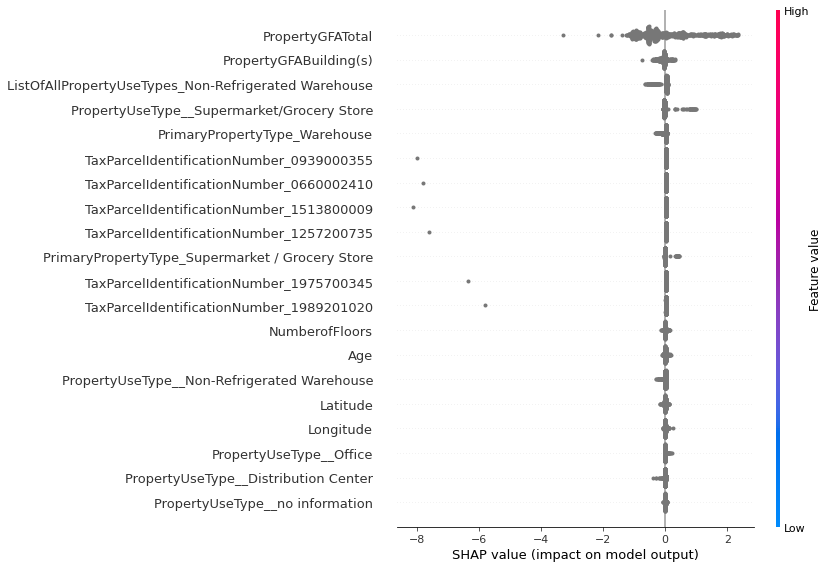

In [208]:
shap.summary_plot(shap_values, forest_max['prepa'].fit_transform(X_train),feature_names=col_shap)

### Importance de la var ENERGYSTARScore

In [118]:
df_fin = df_clean_log

In [119]:
X=df_fin.copy().drop([cible1,'ENERGYSTARScore'],axis=1)
y = df_fin[cible1]

In [120]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y,test_size=0.2,random_state=0)

In [121]:
forest_max = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=138, max_depth =14,
                                                                               min_samples_leaf=1
                                                                              ))])

forest_max = forest_max.fit (X_train2, y_train2)
y_pred = forest_max.predict(X_test2)

forest_max.score(X_test2, y_test2)

ls_m = np.array([mean_squared_error(y_test2, y_pred, squared=False),
mean_absolute_error(y_test2, y_pred),
r2_score(y_test2, y_pred)])

df_sansES = pd.DataFrame(ls_m,index=['RMSE','MAE','R2'],columns=['Sans ENERGYSTARScore']).T
df_sansES

,RMSE,MAE,R2
Sans ENERGYSTARScore,0.611687,0.437901,0.693065


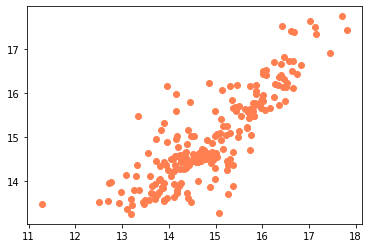

In [122]:
plt.scatter(y_test2, y_pred, color='coral')

**Avec Energy Score**

In [123]:
df_fin2= df_clean_log

X2=df_fin2.copy().drop([cible1],axis=1)
X2=X2[X2['ENERGYSTARScore']>0]

In [124]:
X_train2b, X_test2b, y_train2b, y_test2b = train_test_split(X2, y,test_size=0.2,random_state=0)

In [153]:
forest_max = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=138, max_depth =14,
                                                                               min_samples_leaf=1
                                                                              ))])

forest_max = forest_max.fit (X_train2b, y_train2b)
y_pred = forest_max.predict(X_test2b)

forest_max.score(X_test2b, y_test2b)

ls_mb = np.array([mean_squared_error(y_test2b, y_pred, squared=False),
mean_absolute_error(y_test2b, y_pred),
r2_score(y_test2b, y_pred)])

df_avecES = pd.DataFrame(ls_mb,index=['RMSE','MAE','R2'],columns=['Avec ENERGYSTARScore']).T
df_avecES

,RMSE,MAE,R2
Avec ENERGYSTARScore,0.568523,0.403903,0.734855


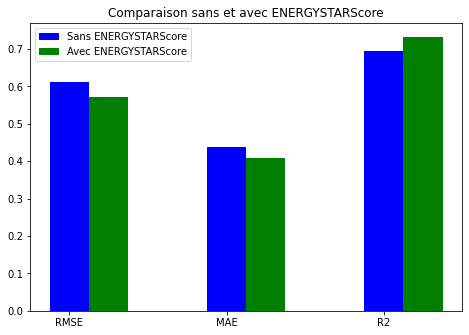

In [126]:
plot_metrics3(df_sansES,df_avecES)

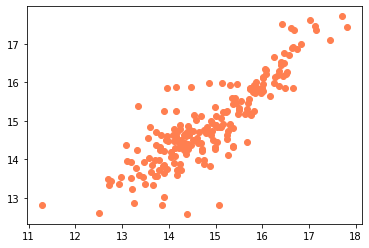

In [127]:
plt.scatter(y_test2b, y_pred, color='coral')

[ 77 155 233 311 389 467 545 623 701 779]


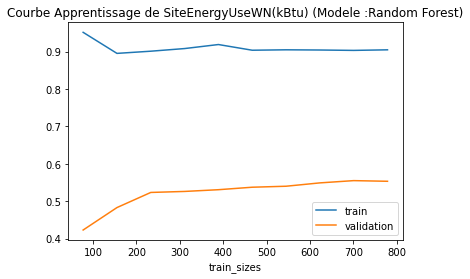

In [157]:
from sklearn.model_selection import learning_curve
forest_max = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(n_estimators=138, max_depth =14,
                                                                               min_samples_leaf=1
                                                                              ))])

N, train_score, val_score = learning_curve(forest_max, X_train2b, y_train2b,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=12)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Courbe Apprentissage de SiteEnergyUseWN(kBtu) (Modele :Random Forest)')
plt.legend()